In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.optim import Adam

In [2]:
class Loss(nn.Module):

    def __init__(self, n):
        super().__init__()
        self.beta_tilde = nn.Parameter(torch.randn(n - 1, 1) / 100)
        self.gamma_tilde = nn.Parameter(torch.randn(n - 1, 1) / 100)
        self.delta_tilde = nn.Parameter(torch.randn(n - 1, 1) / 100)

    def forward(self, N, I, D):
        S = N - I - D

        dS = S[1:] - S[:-1]
        dI = I[1:] - I[:-1]
        dD = D[1:] - D[:-1]

        delta = torch.exp(self.delta_tilde)
        gamma = torch.exp(self.gamma_tilde)
        beta = torch.exp(self.beta_tilde)

        dD_term = dD - gamma * I[:-1]
        dI_term = dI - (beta * I[:-1] * S[:-1] / N) + ((delta + gamma) * I[:-1])
        dS_term = dS - (delta * I[:-1]) + (beta * I[:-1] * S[:-1] / N)

        gamma_second_derivative = 2 * gamma[1:-1] - gamma[:-2] - gamma[2:]
        beta_second_derivative = 2 * beta[1:-1] - beta[:-2] - beta[2:]
        delta_second_derivative = 2 * delta[1:-1] - delta[:-2] - delta[2:]


        return torch.mean(dD_term**2) + torch.mean(dI_term**2) + torch.mean(dS_term**2) + \
        50000 * torch.mean(gamma_second_derivative**2) + 50000 * torch.mean(beta_second_derivative**2) + \
        50000 * torch.mean(delta_second_derivative**2) #+ \
        #10 * torch.mean(delta**2) + 10 * torch.mean(gamma**2) + 10 * torch.mean(beta**2)

In [3]:
N = 50000.

S0 = N - 100.
I0 = 100.
D0 = 0.


St = [S0]
It = [I0]
Dt = [D0]

dt = 1

beta_time_series = 0.41 + 0.02 * torch.sin(torch.arange(100) / 5)
gamma_time_series = 0.1 / (1 - torch.exp(-(10 + torch.arange(100)) / 50))
delta = 0.01


for i in range(100 - 1):

    beta = beta_time_series[i]
    gamma = gamma_time_series[i]

    dS = (delta * It[-1]) - (beta * St[-1] * It[-1] / N)
    dI = (beta * St[-1] * It[-1] / N) - (delta * It[-1]) - (gamma * It[-1])
    dD = gamma * It[-1]

    S = St[-1] + (dt * dS)
    I = It[-1] + (dt * dI)
    D = Dt[-1] + (dt * dD)

    St.append(S)
    It.append(I)
    Dt.append(D)

St = torch.tensor(St)
It = torch.tensor(It)
Dt = torch.tensor(Dt)

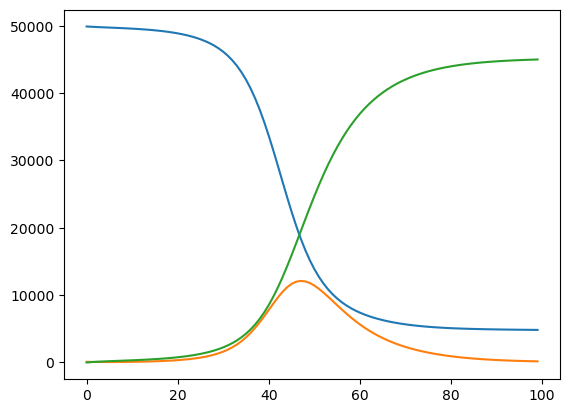

In [4]:
plt.plot(St)
plt.plot(It)
plt.plot(Dt)

## load in data for AK, assuming covid lasts for 20 days

In [5]:
data = pd.read_csv('../data/jhu-covid-cases.csv')
data = data[data.Province_State == 'Alaska']
data = data[data.columns[11:]]
print(data.columns[:5])

death = pd.read_csv('../data/jhu-covid-deaths.csv')
death = death[death.Province_State == 'Alaska']
death = death[death.columns[12:]]
print(death.columns[:5]) # make sure the dates match

data = np.array(data.sum(axis = 0)) #.reshape(-1, 1)
data = np.convolve(data, np.ones(7) / 7, 'valid')
data = torch.tensor(data).reshape(-1, 1)
It = data[20:] - data[:-20]

death = torch.tensor(death.sum(axis = 0))
Dt = torch.tensor(np.convolve(death, np.ones(7) / 7, 'valid'))
Dt = Dt.reshape(-1, 1)[:-20] * 1.

N = 733_583 # alaska population 2022 (assume constant)

print(It.shape, Dt.shape) # make sure shapes match 

Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20'], dtype='object')
Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20'], dtype='object')
torch.Size([1117, 1]) torch.Size([1117, 1])


In [6]:
It = It[30:] # so there are some cases when we begin
Dt = Dt[30:]

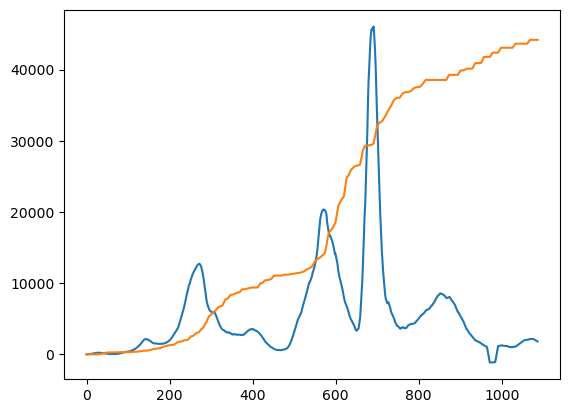

In [7]:
plt.plot(It)
plt.plot(30 * Dt)

In [8]:
loss = Loss(It.size(0))
optimizer = Adam(loss.parameters(), lr = 1e-3)

EPOCHS = 50000

for i in range(EPOCHS):

    optimizer.zero_grad()
    
    l = loss(N, It, Dt)
    l.backward()

    optimizer.step()


    if i % 100 == 0:
        print('=== Epoch', i, '| Loss:', l.item(), '===')
    


=== Epoch 0 | Loss: 179360652.3275698 ===
=== Epoch 100 | Loss: 124166648.51728421 ===
=== Epoch 200 | Loss: 94848713.7599738 ===
=== Epoch 300 | Loss: 78952398.33315241 ===
=== Epoch 400 | Loss: 68649189.9444882 ===
=== Epoch 500 | Loss: 60622364.833218455 ===
=== Epoch 600 | Loss: 53877899.962255724 ===
=== Epoch 700 | Loss: 48108994.34222984 ===
=== Epoch 800 | Loss: 43148094.53387283 ===
=== Epoch 900 | Loss: 38862787.019644246 ===
=== Epoch 1000 | Loss: 35142776.75567193 ===
=== Epoch 1100 | Loss: 31896936.8107999 ===
=== Epoch 1200 | Loss: 29050437.174973473 ===
=== Epoch 1300 | Loss: 26541897.75812781 ===
=== Epoch 1400 | Loss: 24320853.93067515 ===
=== Epoch 1500 | Loss: 22345669.636064965 ===
=== Epoch 1600 | Loss: 20581835.434262555 ===
=== Epoch 1700 | Loss: 19000595.950425 ===
=== Epoch 1800 | Loss: 17577881.868436027 ===
=== Epoch 1900 | Loss: 16293432.784882363 ===
=== Epoch 2000 | Loss: 15130112.636761457 ===
=== Epoch 2100 | Loss: 14073353.94569806 ===
=== Epoch 2200 | 

In [9]:
gamma_train = torch.exp(loss.gamma_tilde.detach())
delta_train = torch.exp(loss.delta_tilde.detach())
beta_train = torch.exp(loss.beta_tilde.detach())

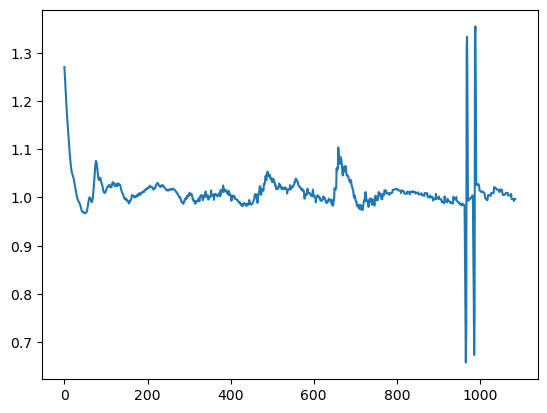

In [10]:
plt.plot(beta_train)

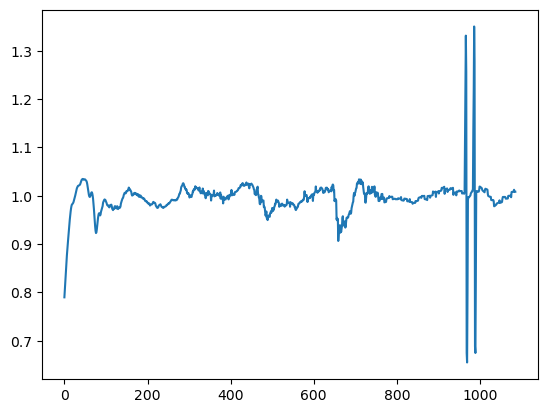

In [11]:
plt.plot(delta_train)

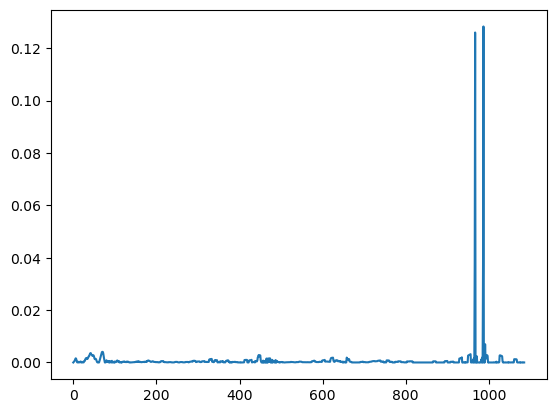

In [12]:
plt.plot(gamma_train)

### simulation

In [13]:
S0 = N - It[0] - Dt[0]
I0 = It[0]
D0 = Dt[0]


St_sim = [S0]
It_sim = [I0]
Dt_sim = [D0]

dt = 1

for i in range(200 - 1):

    beta = beta_train[i]
    gamma = gamma_train[i]
    delta = delta_train[i]

    dS = (delta * It_sim[-1]) - (beta * St_sim[-1] * It_sim[-1] / N)
    dI = (beta * St_sim[-1] * It_sim[-1] / N) - (delta * It_sim[-1]) - (gamma * It_sim[-1])
    dD = gamma * It_sim[-1]

    S = St_sim[-1] + (dt * dS)
    I = It_sim[-1] + (dt * dI)
    D = Dt_sim[-1] + (dt * dD)

    St_sim.append(S)
    It_sim.append(I)
    Dt_sim.append(D)

St_sim = torch.tensor(St_sim)
It_sim = torch.tensor(It_sim)
Dt_sim = torch.tensor(Dt_sim)

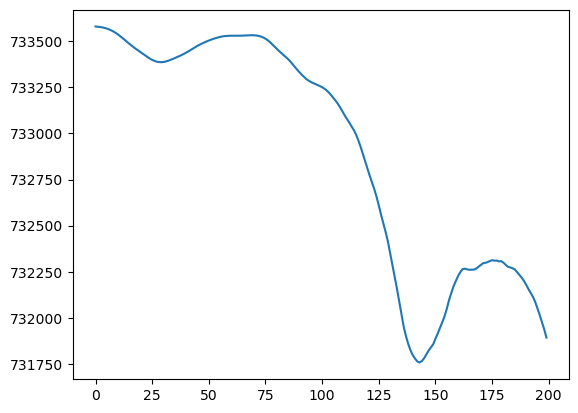

In [14]:
plt.plot(St_sim)
#plt.plot(St)

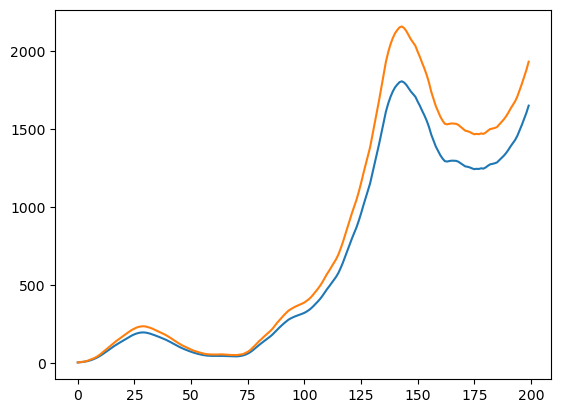

In [15]:
plt.plot(It_sim)
plt.plot(It[:200])

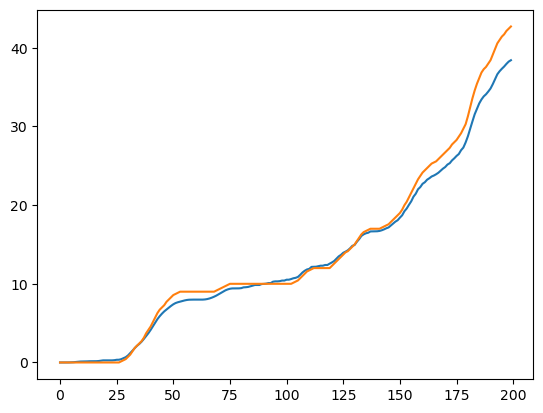

In [16]:
plt.plot(Dt_sim)
plt.plot(Dt[:200])